<h1 id="oversampling_for_multiclass_classification_of_accidents">Oversampling on the Order of the Smallest Class for Multiclass Classification of Automobile Accidents in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7fc430361f70>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.352710516948719 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.368111673975363 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.51084306096891 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical columns.
df_categorical = df_converted.select_dtypes(include="category")

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.21598074794747 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,Clear,Dry,Daylight
5,1,Rear Ended,Clear,Dry,Daylight
6,1,Other,Clear,Wet,Daylight
8,1,Sideswipe,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SEVERITYCODE   171872 non-null  category
 1   COLLISIONTYPE  171872 non-null  category
 2   WEATHER        171872 non-null  category
 3   ROADCOND       171872 non-null  category
 4   LIGHTCOND      171872 non-null  category
dtypes: category(5)
memory usage: 2.1 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.626575611997396 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.963935535983182 seconds.


<h2 id='sample_size_class_3'>Sample all classes equally, with the number of samples equal to the size of class '3'<\h2>

In [34]:
sample_size_class_1 = np.int(class_3_size)
sample_size_class_2 = np.int(class_3_size)
sample_size_class_2b = np.int(class_3_size)
sample_size_class_3 = np.int(class_3_size)

In [35]:
# Sample all classes equally, with the number of samples equal to the size of class '3'.
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1, replace=False, weights=None, axis='index', random_state=seed)
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=False, weights=None, axis='index', random_state=seed)
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=False, weights=None, axis='index', random_state=seed)
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=False, weights=None, axis='index', random_state=seed)

In [36]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [37]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced_undersampled = shuffle(df_balanced_not_shuffled, random_state=seed)

In [38]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_undersampled["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b    328
2     328
1     328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_undersampled["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_balanced_undersampled[["COLLISIONTYPE", "WEATHER", "ROADCOND", "LIGHTCOND"]]

We also define the data for the target variable, SEVERITYCODE, by the array y:

In [41]:
y = df_balanced_undersampled["SEVERITYCODE"].to_numpy()

In [42]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.115729323995765 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [43]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.categories_)

Fitting OneHotEncoder to training data...
Completed in 0.025809733953792602 seconds.
[array(['Angles', 'Cycles', 'Head On', 'Left Turn', 'Other', 'Parked Car',
       'Pedestrian', 'Rear Ended', 'Right Turn', 'Sideswipe'],
      dtype=object), array(['Clear', 'Fog/Smog/Smoke', 'Other', 'Overcast', 'Partly Cloudy',
       'Raining', 'Severe Crosswind', 'Snowing'], dtype=object), array(['Dry', 'Ice', 'Snow/Slush', 'Standing Water', 'Wet'], dtype=object), array(['Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dawn', 'Daylight', 'Dusk', 'Other'],
      dtype=object)]


In [44]:
type(X)

scipy.sparse.csr.csr_matrix

In [45]:
X.shape

(1312, 30)

In [46]:
y.shape

(1312,)

In [47]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.627404846949503 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [48]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [49]:
t0 = default_timer()
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'neg_log_loss','precision_macro', 'recall_macro']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print_elapsed_time(t0)

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_neg_log_loss', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 7.673717404017225 seconds.


In [50]:
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

fit_time: mean = 0.359291, std = 0.028040
fit_time :[0.34401751 0.34631038 0.36463094 0.39960718 0.33839631 0.35271168
 0.33588576 0.37930775 0.41232419 0.31972051]

score_time: mean = 0.027114, std = 0.002616
score_time :[0.02847219 0.03006244 0.02930403 0.02401614 0.02454686 0.02978373
 0.02656889 0.02414894 0.03033495 0.02390313]

test_f1_macro: mean = 0.456493, std = 0.026608
test_f1_macro :[0.44924409 0.45412488 0.3992172  0.46032048 0.43360462 0.46434267
 0.49308079 0.44936177 0.49767376 0.46395842]

test_neg_log_loss: mean = -1.172370, std = 0.046120
test_neg_log_loss :[-1.11702044 -1.18023415 -1.22253103 -1.22489534 -1.16186497 -1.24593424
 -1.108512   -1.19022225 -1.1231743  -1.14931423]

test_precision_macro: mean = 0.470266, std = 0.027726
test_precision_macro :[0.45773504 0.47361348 0.41168788 0.46700001 0.45388072 0.46599505
 0.50786565 0.46021846 0.51279539 0.49187009]

test_recall_macro: mean = 0.468158, std = 0.030347
test_recall_macro :[0.45454545 0.45454545 0.40340909

In [51]:
print_elapsed_time(notebook_start_time)

Elapsed time is 29.6939881509752 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [52]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [53]:
t0 = default_timer()
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=1000), verbose=True)
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print_elapsed_time(t0)

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']
Elapsed time is 2.3415305559756234 seconds.


In [54]:
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

fit_time: mean = 0.417414, std = 0.105488
fit_time :[0.45361757 0.52442932 0.54134297 0.52074194 0.48886204 0.47073698
 0.29359102 0.2624743  0.33883762 0.27950358]

score_time: mean = 0.026598, std = 0.007877
score_time :[0.02447534 0.02569556 0.03876376 0.04300404 0.02296853 0.0172863
 0.02603006 0.01721215 0.02702379 0.02351928]

test_f1_macro: mean = 0.457733, std = 0.024032
test_f1_macro :[0.45078212 0.43993751 0.41295322 0.45617797 0.44051483 0.46434267
 0.492586   0.45624964 0.50030481 0.46348456]

test_precision_macro: mean = 0.476864, std = 0.026106
test_precision_macro :[0.45934535 0.47484233 0.42856035 0.46108164 0.47201087 0.46599505
 0.51799242 0.47245951 0.51554113 0.50081028]

test_recall_macro: mean = 0.471993, std = 0.030434
test_recall_macro :[0.46212121 0.43939394 0.41856061 0.47111742 0.45667614 0.47324811
 0.52864583 0.47466856 0.51302083 0.48248106]



In [55]:
print_elapsed_time(notebook_start_time)

Elapsed time is 32.42752401798498 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [56]:
t0 = default_timer()
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
n_splits = kfold_cv.get_n_splits()
# To avoid ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1180, n_neighbors = 1311,
# define maximum_number_of_neighbors.
# maximum_number_of_neighbors = np.int(X.shape[0] / kfold_cv.get_n_splits()) # Smaller because of test set in cross-validation
maximum_number_of_neighbors = np.int(X.shape[0] * (n_splits - 1)/n_splits)
print('Maximum number of neighbors = %d.' % maximum_number_of_neighbors)
k_neighbors_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(n_neighbors=maximum_number_of_neighbors, weights='distance', algorithm='auto', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=-1), verbose=True)
scoring = ['f1_macro', 'precision_macro', 'recall_macro']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

Maximum number of neighbors = 1180.
k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']
k-Neighbors Classifiers constructed in 1.963154 seconds.


In [57]:
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

fit_time: mean = 0.029181, std = 0.007317
fit_time :[0.01725888 0.01558495 0.02863193 0.03650761 0.02961493 0.03310537
 0.03610969 0.02580857 0.03136778 0.03782034]

score_time: mean = 0.283309, std = 0.050779
score_time :[0.29886889 0.3096714  0.22002745 0.33236647 0.39289808 0.2458446
 0.28635788 0.22157145 0.24938083 0.27609944]

test_f1_macro: mean = 0.432643, std = 0.046054
test_f1_macro :[0.47892733 0.41210021 0.38122783 0.4851774  0.40710104 0.418102
 0.49185223 0.36729853 0.48930645 0.39533883]

test_precision_macro: mean = 0.449313, std = 0.048975
test_precision_macro :[0.49912587 0.43848814 0.3860306  0.4939334  0.42801932 0.43728949
 0.50870408 0.37917682 0.51625    0.40611018]

test_recall_macro: mean = 0.445076, std = 0.047477
test_recall_macro :[0.49242424 0.41666667 0.38825758 0.49431818 0.41903409 0.42826705
 0.51254735 0.38873106 0.50497159 0.40553977]



In [58]:
print_elapsed_time(notebook_start_time)

Elapsed time is 34.735212996951304 seconds.


## Sanity Check

In [59]:
t0 = default_timer()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, shuffle=True, stratify=y)

Logistic Regression Model 1 of 10:
mean accuracy = 0.5171102661596958
Jaccard scores by class: [0.43373494 0.3539823  0.1954023  0.40186916]
              precision    recall  f1-score   support

           1   0.679245  0.545455  0.605042        66
           2   0.454545  0.615385  0.522876        65
          2b   0.447368  0.257576  0.326923        66
           3   0.511905  0.651515  0.573333        66

    accuracy                       0.517110       263
   macro avg   0.523266  0.517483  0.507044       263
weighted avg   0.523527  0.517110  0.506983       263



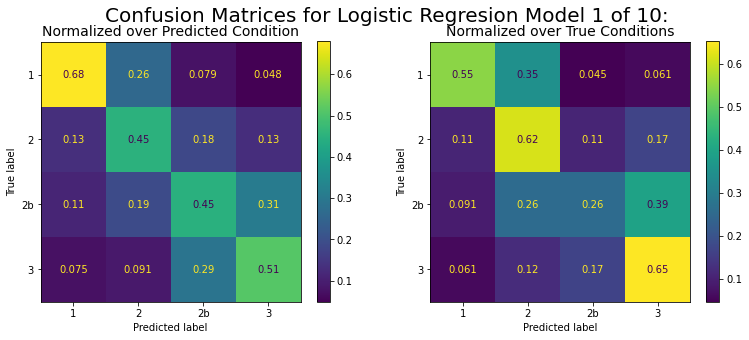

Logistic Regression Model 2 of 10:
mean accuracy = 0.532319391634981
Jaccard scores by class: [0.44186047 0.35135135 0.21590909 0.43564356]
              precision    recall  f1-score   support

           1   0.655172  0.575758  0.612903        66
           2   0.458824  0.600000  0.520000        65
          2b   0.463415  0.287879  0.355140        66
           3   0.556962  0.666667  0.606897        66

    accuracy                       0.532319       263
   macro avg   0.533593  0.532576  0.523735       263
weighted avg   0.533877  0.532319  0.523749       263



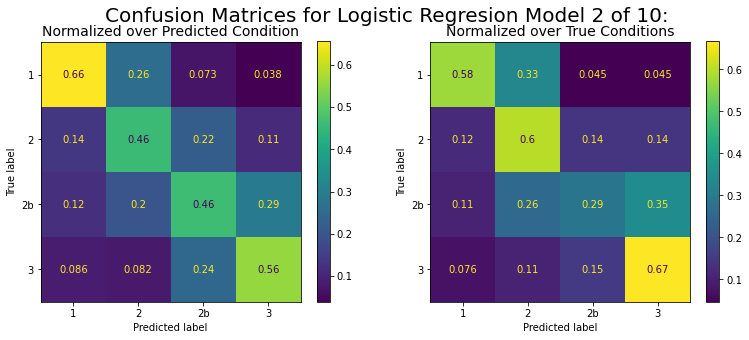

Logistic Regression Model 3 of 10:
mean accuracy = 0.5437262357414449
Jaccard scores by class: [0.46428571 0.37272727 0.20481928 0.43396226]
              precision    recall  f1-score   support

           1   0.684211  0.590909  0.634146        66
           2   0.476744  0.630769  0.543046        65
          2b   0.500000  0.257576  0.340000        66
           3   0.534884  0.696970  0.605263        66

    accuracy                       0.543726       263
   macro avg   0.548960  0.544056  0.530614       263
weighted avg   0.549234  0.543726  0.530567       263



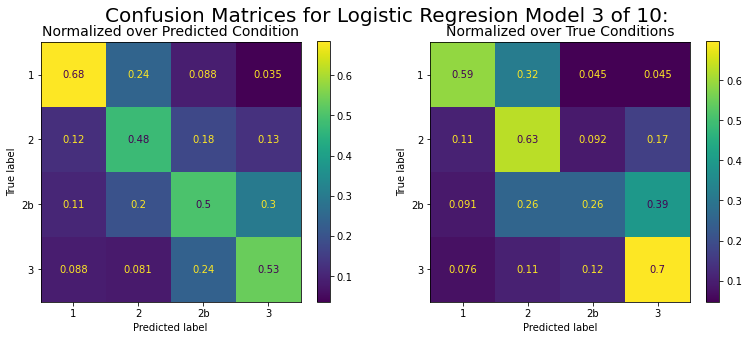

Logistic Regression Model 4 of 10:
mean accuracy = 0.5361216730038023
Jaccard scores by class: [0.44705882 0.35135135 0.22727273 0.43564356]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.458824  0.600000  0.520000        65
          2b   0.476190  0.303030  0.370370        66
           3   0.556962  0.666667  0.606897        66

    accuracy                       0.536122       263
   macro avg   0.539661  0.536364  0.528788       263
weighted avg   0.539968  0.536122  0.528822       263



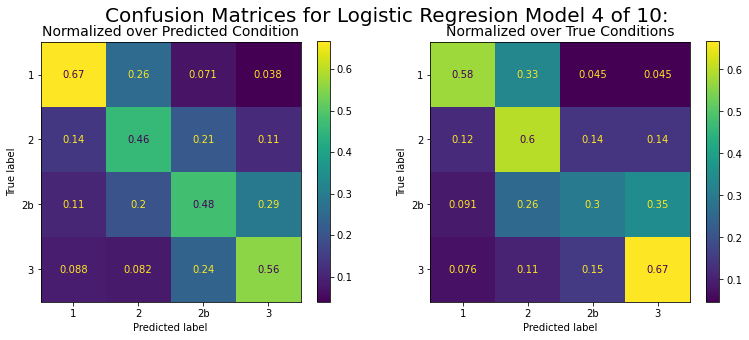

Logistic Regression Model 5 of 10:
mean accuracy = 0.5361216730038023
Jaccard scores by class: [0.44578313 0.37168142 0.21590909 0.42574257]
              precision    recall  f1-score   support

           1   0.685185  0.560606  0.616667        66
           2   0.466667  0.646154  0.541935        65
          2b   0.463415  0.287879  0.355140        66
           3   0.551282  0.651515  0.597222        66

    accuracy                       0.536122       263
   macro avg   0.541637  0.536538  0.527741       263
weighted avg   0.541922  0.536122  0.527687       263



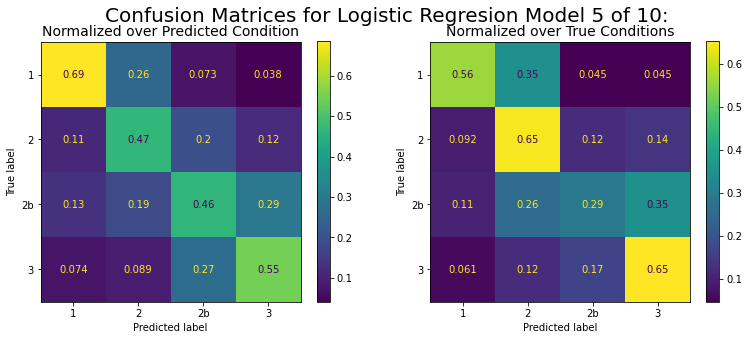

Logistic Regression Model 6 of 10:
mean accuracy = 0.5399239543726235
Jaccard scores by class: [0.44705882 0.36936937 0.20731707 0.43396226]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.471264  0.630769  0.539474        65
          2b   0.515152  0.257576  0.343434        66
           3   0.534884  0.696970  0.605263        66

    accuracy                       0.539924       263
   macro avg   0.546992  0.540268  0.526514       263
weighted avg   0.547280  0.539924  0.526465       263



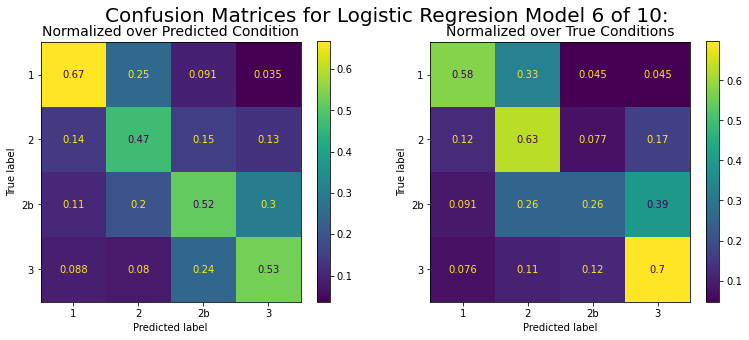

Logistic Regression Model 7 of 10:
mean accuracy = 0.5247148288973384
Jaccard scores by class: [0.44705882 0.35       0.19512195 0.41584158]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.432990  0.646154  0.518519        65
          2b   0.500000  0.242424  0.326531        66
           3   0.545455  0.636364  0.587413        66

    accuracy                       0.524715       263
   macro avg   0.536278  0.525175  0.512587       263
weighted avg   0.536670  0.524715  0.512564       263



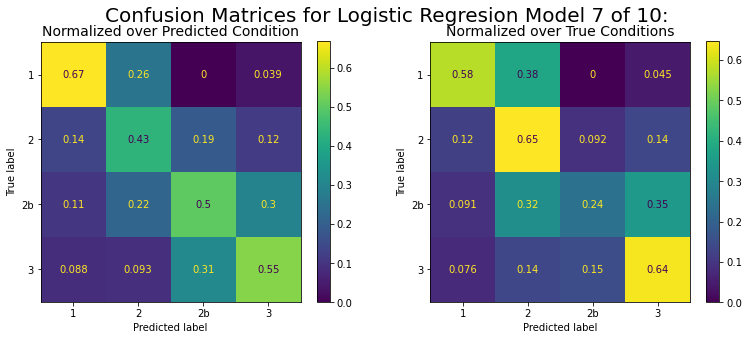

Logistic Regression Model 8 of 10:
mean accuracy = 0.532319391634981
Jaccard scores by class: [0.44705882 0.36666667 0.17333333 0.4245283 ]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.444444  0.676923  0.536585        65
          2b   0.590909  0.196970  0.295455        66
           3   0.529412  0.681818  0.596026        66

    accuracy                       0.532319       263
   macro avg   0.557858  0.532867  0.511488       263
weighted avg   0.558289  0.532319  0.511393       263



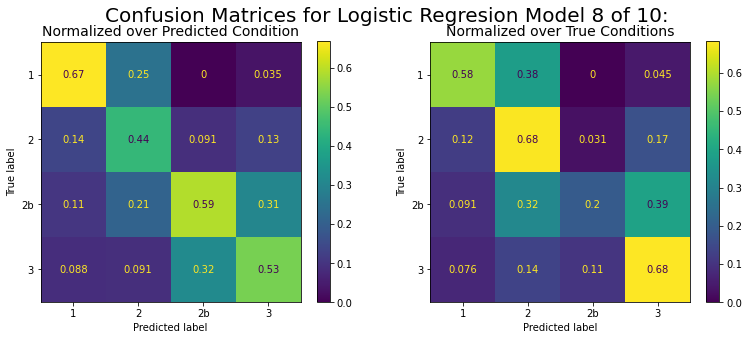

Logistic Regression Model 9 of 10:
mean accuracy = 0.5361216730038023
Jaccard scores by class: [0.45238095 0.36036036 0.2247191  0.42574257]
              precision    recall  f1-score   support

           1   0.678571  0.575758  0.622951        66
           2   0.465116  0.615385  0.529801        65
          2b   0.465116  0.303030  0.366972        66
           3   0.551282  0.651515  0.597222        66

    accuracy                       0.536122       263
   macro avg   0.540022  0.536422  0.529237       263
weighted avg   0.540306  0.536122  0.529235       263



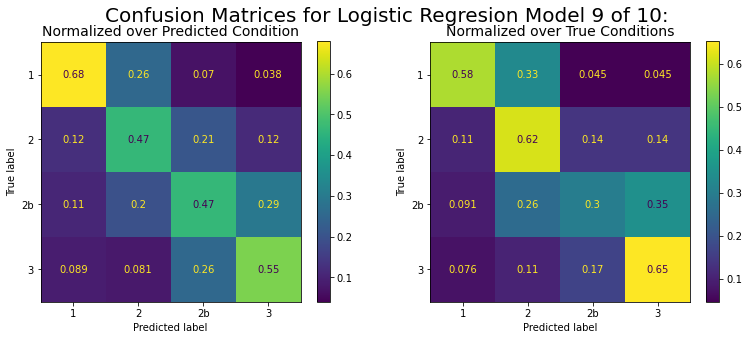

Logistic Regression Model 10 of 10:
mean accuracy = 0.532319391634981
Jaccard scores by class: [0.44705882 0.36036036 0.20238095 0.4245283 ]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.465116  0.615385  0.529801        65
          2b   0.485714  0.257576  0.336634        66
           3   0.529412  0.681818  0.596026        66

    accuracy                       0.532319       263
   macro avg   0.536727  0.532634  0.520087       263
weighted avg   0.537000  0.532319  0.520050       263



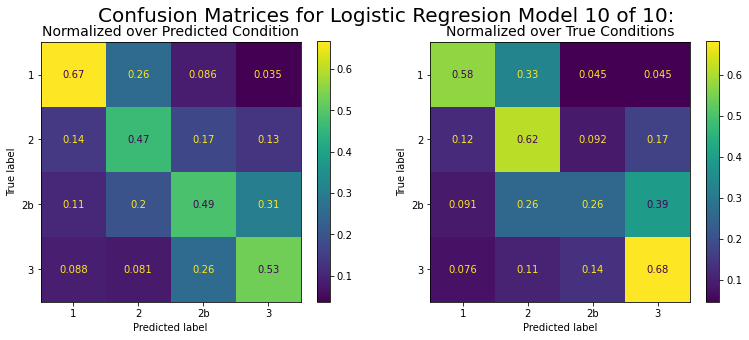

In [61]:
# For each logistic regression classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    lr_clf_score = logistic_regression_clf.score(X_test, y_test)
    y_test_predicted = logistic_regression_clf.predict(X_test)
    lr_clf_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print('mean accuracy =', lr_clf_score)
    print('Jaccard scores by class:', lr_clf_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 2, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regresion Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,2,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=14)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred', ax=ax)
    
    ax = plt.subplot(1,2,2)
    ax.set_title("Normalized over True Conditions", fontsize=14)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true', ax=ax)
    
    plt.show()

In [62]:
print_elapsed_time()

Elapsed time is 58.22430667298613 seconds.


Support Vector Machine Model 1 of 10:
mean accuracy = 0.5247148288973384
Jaccard scores by class: [0.45121951 0.3539823  0.18823529 0.41666667]
              precision    recall  f1-score   support

           1   0.698113  0.560606  0.621849        66
           2   0.454545  0.615385  0.522876        65
          2b   0.457143  0.242424  0.316832        66
           3   0.517241  0.681818  0.588235        66

    accuracy                       0.524715       263
   macro avg   0.531761  0.525058  0.512448       263
weighted avg   0.532054  0.524715  0.512408       263



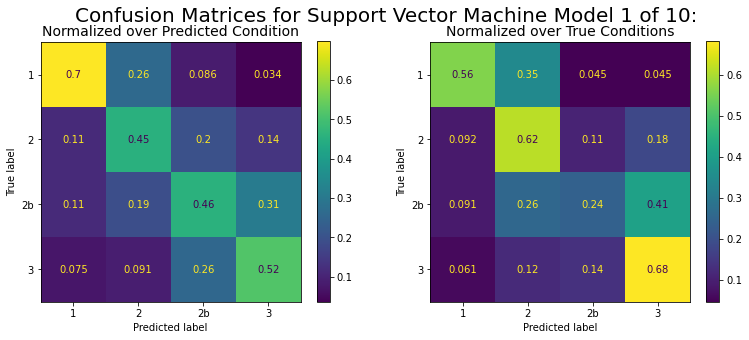

Support Vector Machine Model 2 of 10:
mean accuracy = 0.5285171102661597
Jaccard scores by class: [0.44578313 0.34821429 0.21590909 0.42307692]
              precision    recall  f1-score   support

           1   0.685185  0.560606  0.616667        66
           2   0.453488  0.600000  0.516556        65
          2b   0.463415  0.287879  0.355140        66
           3   0.536585  0.666667  0.594595        66

    accuracy                       0.528517       263
   macro avg   0.534668  0.528788  0.520739       263
weighted avg   0.534977  0.528517  0.520755       263



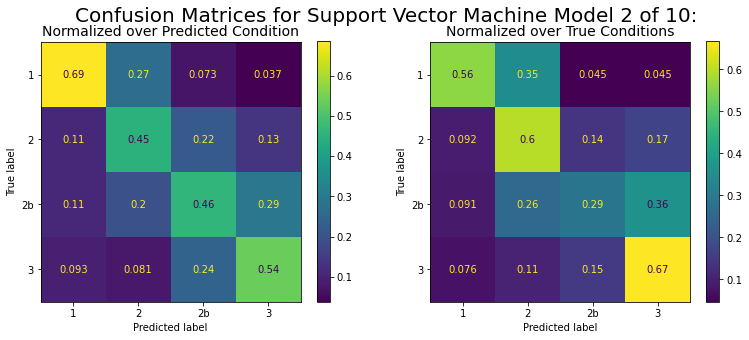

Support Vector Machine Model 3 of 10:
mean accuracy = 0.5399239543726235
Jaccard scores by class: [0.45679012 0.36607143 0.19753086 0.43636364]
              precision    recall  f1-score   support

           1   0.711538  0.560606  0.627119        66
           2   0.465909  0.630769  0.535948        65
          2b   0.516129  0.242424  0.329897        66
           3   0.521739  0.727273  0.607595        66

    accuracy                       0.539924       263
   macro avg   0.553829  0.540268  0.525140       263
weighted avg   0.554163  0.539924  0.525098       263



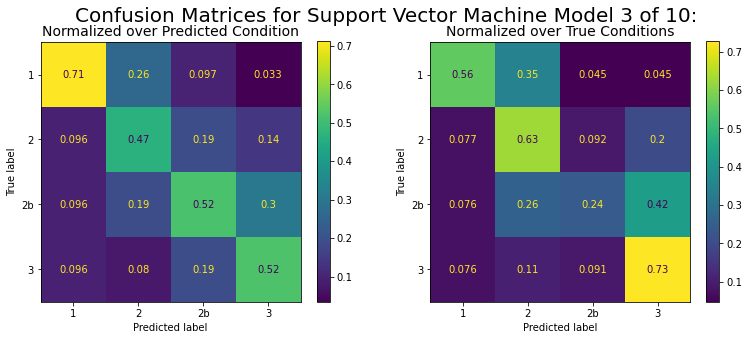

Support Vector Machine Model 4 of 10:
mean accuracy = 0.532319391634981
Jaccard scores by class: [0.44705882 0.35135135 0.20238095 0.43396226]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.458824  0.600000  0.520000        65
          2b   0.485714  0.257576  0.336634        66
           3   0.534884  0.696970  0.605263        66

    accuracy                       0.532319       263
   macro avg   0.536522  0.532576  0.519946       263
weighted avg   0.536817  0.532319  0.519946       263



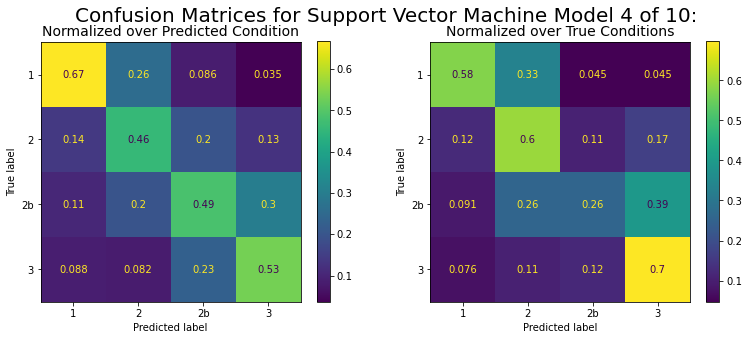

Support Vector Machine Model 5 of 10:
mean accuracy = 0.5285171102661597
Jaccard scores by class: [0.45121951 0.36283186 0.19767442 0.41509434]
              precision    recall  f1-score   support

           1   0.698113  0.560606  0.621849        66
           2   0.460674  0.630769  0.532468        65
          2b   0.459459  0.257576  0.330097        66
           3   0.523810  0.666667  0.586667        66

    accuracy                       0.528517       263
   macro avg   0.535514  0.528904  0.517770       263
weighted avg   0.535799  0.528517  0.517714       263



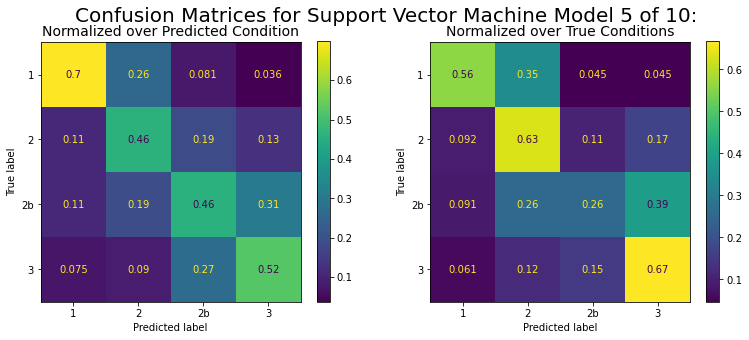

Support Vector Machine Model 6 of 10:
mean accuracy = 0.5437262357414449
Jaccard scores by class: [0.44705882 0.36936937 0.20987654 0.44339623]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.471264  0.630769  0.539474        65
          2b   0.531250  0.257576  0.346939        66
           3   0.540230  0.712121  0.614379        66

    accuracy                       0.543726       263
   macro avg   0.552353  0.544056  0.529669       263
weighted avg   0.552661  0.543726  0.529632       263



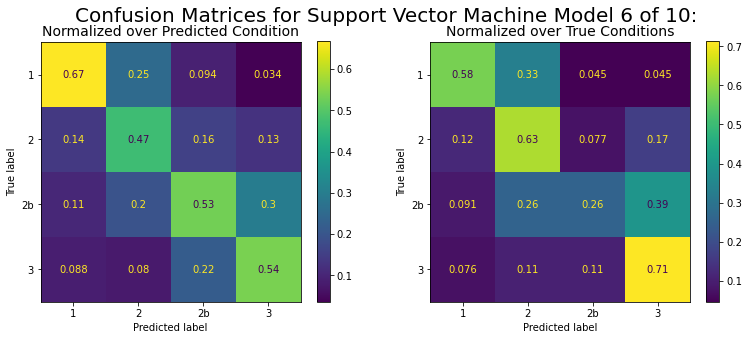

Support Vector Machine Model 7 of 10:
mean accuracy = 0.5247148288973384
Jaccard scores by class: [0.44705882 0.35833333 0.16883117 0.41509434]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.438776  0.661538  0.527607        65
          2b   0.541667  0.196970  0.288889        66
           3   0.523810  0.666667  0.586667        66

    accuracy                       0.524715       263
   macro avg   0.542730  0.525233  0.505262       263
weighted avg   0.543125  0.524715  0.505177       263



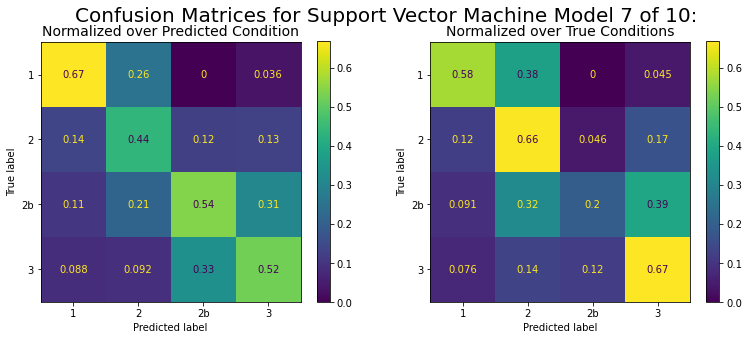

Support Vector Machine Model 8 of 10:
mean accuracy = 0.532319391634981
Jaccard scores by class: [0.44705882 0.36666667 0.17333333 0.4245283 ]
              precision    recall  f1-score   support

           1   0.666667  0.575758  0.617886        66
           2   0.444444  0.676923  0.536585        65
          2b   0.590909  0.196970  0.295455        66
           3   0.529412  0.681818  0.596026        66

    accuracy                       0.532319       263
   macro avg   0.557858  0.532867  0.511488       263
weighted avg   0.558289  0.532319  0.511393       263



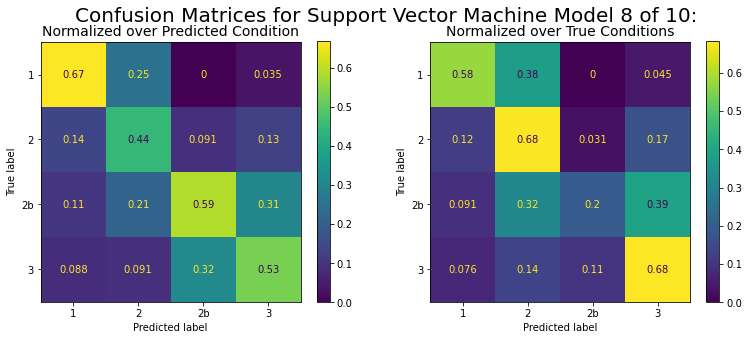

Support Vector Machine Model 9 of 10:
mean accuracy = 0.532319391634981
Jaccard scores by class: [0.45238095 0.36036036 0.2        0.4245283 ]
              precision    recall  f1-score   support

           1   0.678571  0.575758  0.622951        66
           2   0.465116  0.615385  0.529801        65
          2b   0.472222  0.257576  0.333333        66
           3   0.529412  0.681818  0.596026        66

    accuracy                       0.532319       263
   macro avg   0.536330  0.532634  0.520528       263
weighted avg   0.536601  0.532319  0.520493       263



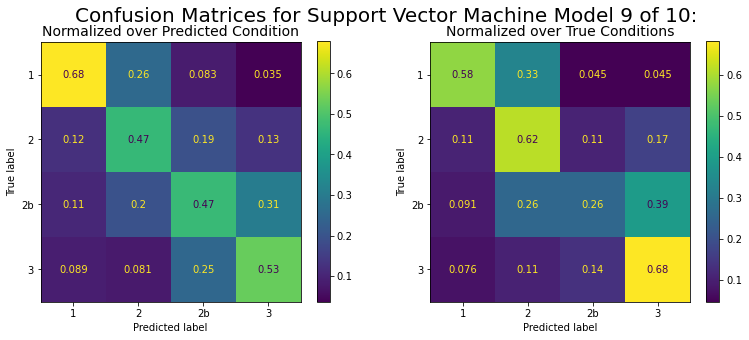

Support Vector Machine Model 10 of 10:
mean accuracy = 0.5361216730038023
Jaccard scores by class: [0.45679012 0.36283186 0.20481928 0.42592593]
              precision    recall  f1-score   support

           1   0.711538  0.560606  0.627119        66
           2   0.460674  0.630769  0.532468        65
          2b   0.500000  0.257576  0.340000        66
           3   0.522727  0.696970  0.597403        66

    accuracy                       0.536122       263
   macro avg   0.548735  0.536480  0.524247       263
weighted avg   0.549070  0.536122  0.524216       263



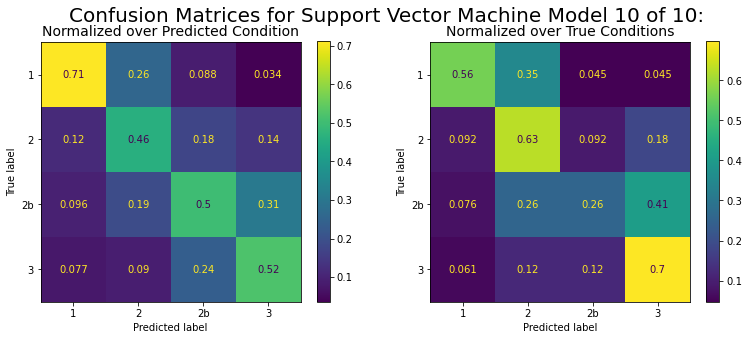

In [63]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    linear_svc_score = linear_svc_clf.score(X_test, y_test)
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print('mean accuracy =', linear_svc_score)
    print('Jaccard scores by class:', linear_svc_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=['1', '2', '2b', '3'], target_names=['1', '2', '2b', '3'], digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 2, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,2,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=14)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='pred', ax=ax)
    
    ax = plt.subplot(1,2,2)
    ax.set_title("Normalized over True Conditions", fontsize=14)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=['1', '2', '2b', '3'], display_labels=['1', '2', '2b', '3'], normalize='true', ax=ax)
    
    plt.show()

In [64]:
print('Graphics and reports generated in %f seconds' % elapsed_time(t0))

Graphics and reports generated in 44.885609 seconds


In [65]:
print_elapsed_time(notebook_start_time)

Elapsed time is 79.81937419896713 seconds.
